# Exploring AirBnB in Athens


* 1st Assignment of the Applied Machine Learning Class of 2023-24

---

> Author: Theodoros Skondras Mexis <br />
> Department of Management Science and Technology
> Email: t8200156@aueb.gr <br />
> Github:https://github.com/TeoSkondras <br />

* First of all import all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde

import folium
from folium.plugins import MarkerCluster

import plotly.express as px

* Then create dataframes for each one of the csv files.
* Note: Suppose the data are on a data directory, you can delete "data/" if you have them on the same directory as the notebook.

In [2]:
calendar = pd.read_csv("data/calendar.csv.gz")
listings = pd.read_csv("data/listings.csv.gz")
neighborhoods = pd.read_csv("data/neighbourhoods.csv")
# neighborhoods_geo = pd.read_json("data/neighbourhoods.geojson")
reviews = pd.read_csv("data/reviews.csv.gz")

* We can also get them from the website as well,
* but the data is updated every month, so the links need to be updated often, so we will use the local files instead

In [3]:
# calendar = pd.read_csv("http://data.insideairbnb.com/greece/attica/athens/2023-09-21/data/calendar.csv.gz")
# listings = pd.read_csv("http://data.insideairbnb.com/greece/attica/athens/2023-09-21/data/listings.csv.gz")
# neighborhoods = pd.read_csv("http://data.insideairbnb.com/greece/attica/athens/2023-09-21/visualisations/neighbourhoods.csv")
# neighborhoods_geo = pd.read_json("http://data.insideairbnb.com/greece/attica/athens/2023-09-21/visualisations/neighbourhoods.geojson")
# reviews = pd.read_csv("http://data.insideairbnb.com/greece/attica/athens/2023-09-21/visualisations/reviews.csv")

## Neighbourhood Listings in Descending Order (Popularity)

### First approach: Popularity means the number of listings per neighbourhood
* Looking at the csv files we can see that we have a listings dataset and a neighbourhood dataset, so let's see what data & columns they both have, in order to determine how to do the join (if needed)


In [4]:
listings.sample(3)

id                                      listing_url   
9120  711319196037430630  https://www.airbnb.com/rooms/711319196037430630  \
566             11800815            https://www.airbnb.com/rooms/11800815   
2156            24402866            https://www.airbnb.com/rooms/24402866   

           scrape_id last_scraped       source   
9120  20230921043851   2023-09-21  city scrape  \
566   20230921043851   2023-09-21  city scrape   
2156  20230921043851   2023-09-21  city scrape   

                                                   name   
9120  Rental unit in Athina · 1 bedroom · 2 beds · 1...  \
566   Rental unit in Athina · ★4.91 · Studio · 1 bed...   
2156  Condo in Athina · ★4.72 · Studio · 1 bed · 1 bath   

                                            description   
9120  Το Elvita Apartments  βρίσκεται στην ασφαλή πε...  \
566   In the center of Athens 25sq flat, 6th floor (...   
2156  Very cozy studio suitable for 1 or 2 persons i...   

                                  neighborhood_overview   
9120  Pyrgos Athinon/ Athens Towers- 200m,<br />Ippo...  \
566   A huge map of Athens is in the house that can ...   
2156                                                NaN   

                                            picture_url    host_id  ...   
9120  https://a0.muscache.com/pictures/prohost-api/H...  158835185  ...  \
566   https://a0.muscache.com/pictures/34195656-f5a5...   62776805  ...   
2156  https://a0.muscache.com/pictures/25835c94-93e8...   24703234  ...   

     review_scores_communication review_scores_location review_scores_value   
9120                         NaN                    NaN                 NaN  \
566                         4.93                   4.86                4.86   
2156                        4.80                   4.48                4.56   

          license instant_bookable calculated_host_listings_count   
9120  00001794128                t                             21  \
566   00000094952                t                              1   
2156  00000318871                t                             18   

     calculated_host_listings_count_entire_homes   
9120                                          20  \
566                                            1   
2156                                          17   

     calculated_host_listings_count_private_rooms   
9120                                            1  \
566                                             0   
2156                                            1   

     calculated_host_listings_count_shared_rooms reviews_per_month  
9120                                           0               NaN  
566                                            0              2.25  
2156                                           0              0.38  

[3 rows x 75 columns]

* We can see that listings has plenty of neighbourhood-related columns, so we can determine which one of them to join the two datasets, let's take only them with the help of a regex expression

In [5]:
listings.filter(regex="neighbourhood").sample(3)

host_neighbourhood   neighbourhood  neighbourhood_cleansed   
7030             Koukaki  Athina, Greece     ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ  \
11086           Kolonaki             NaN  ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ   
6493              Attiki             NaN             ΝΕΟΣ ΚΟΣΜΟΣ   

       neighbourhood_group_cleansed  
7030                            NaN  
11086                           NaN  
6493                            NaN

In [6]:
neighborhoods.sample(3)

neighbourhood_group             neighbourhood
26                  NaN  ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ
0                   NaN            1Ο ΝΕΚΡΟΤΑΦΕΙΟ
38                  NaN                  ΠΡΟΜΠΟΝΑ

* We can see that both datasets have a column that seems to have similar data, neighbourhood_cleansed in listings and neighbourhood in neighborhoods, so let's see if they have the same values

In [7]:
neighborhood_names_neighbourhoods = neighborhoods["neighbourhood"].unique()
neighborhood_names_listings = listings["neighbourhood_cleansed"].unique()

#check if the values of the second array are in the first array using numpy
result = np.all(np.isin(neighborhood_names_listings, neighborhood_names_neighbourhoods))
print(result)

True


* We can see that the values on the listings dataset are a subset of the values of the neighborhoods dataset, so we can use the neighbourhood_cleansed columnn to show the listings per neighbourghood, with the most popular neighbourhoods first, without the need to join the two datasets

In [8]:
listings_per_neighbourhood = listings.groupby("neighbourhood_cleansed").count().sort_values(by="id", ascending=False)[["id"]].rename(columns={"id": "total_listings"})

In [9]:
listings_per_neighbourhood

total_listings
neighbourhood_cleansed                          
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ                      2416
ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ                         1122
ΝΕΟΣ ΚΟΣΜΟΣ                                  980
ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ                     979
ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ             817
ΠΛΑΤΕΙΑ ΑΤΤΙΚΗΣ                              583
ΠΑΓΚΡΑΤΙ                                     511
ΑΜΠΕΛΟΚΗΠΟΙ                                  452
ΚΟΛΩΝΑΚΙ                                     425
ΑΚΡΟΠΟΛΗ                                     386
ΘΗΣΕΙΟ                                       386
ΠΕΤΡΑΛΩΝΑ                                    352
ΚΕΡΑΜΕΙΚΟΣ                                   343
ΚΥΨΕΛΗ                                       271
ΣΤΑΔΙΟ                                       252
ΓΟΥΔΙ                                        230
ΙΛΙΣΙΑ                                       216
ΠΛΑΤΕΙΑ ΑΜΕΡΙΚΗΣ                             180
ΝΙΡΒΑΝΑ                                      174
ΠΑΤΗΣΙΑ                                      166
ΛΥΚΑΒΗΤΤΟΣ                                   162
ΖΑΠΠΕΙΟ                                      161
ΑΝΩ ΚΥΨΕΛΗ                                   119
ΓΚΥΖΗ                                        118
ΠΕΔΙΟ ΑΡΕΩΣ                                  109
ΚΟΛΩΝΟΣ                                      108
ΓΚΑΖΙ                                        106
ΑΓΙΟΣ ΝΙΚΟΛΑΟΣ                                99
ΣΤΑΘΜΟΣ ΛΑΡΙΣΗΣ                               85
ΒΟΤΑΝΙΚΟΣ                                     80
ΑΚΑΔΗΜΙΑ ΠΛΑΤΩΝΟΣ                             76
ΓΟΥΒΑ                                         75
ΕΛΛΗΝΟΡΩΣΩΝ                                   73
ΝΕΑ ΚΥΨΕΛΗ                                    64
ΑΝΩ ΠΑΤΗΣΙΑ                                   64
1Ο ΝΕΚΡΟΤΑΦΕΙΟ                                55
ΣΕΠΟΛΙΑ                                       45
ΑΓΙΟΣ ΕΛΕΥΘΕΡΙΟΣ                              38
ΠΟΛΥΓΩΝΟ                                      29
ΚΟΛΟΚΥΝΘΟΥ                                    16
ΡΙΖΟΥΠΟΛΗ                                     13
ΠΡΟΜΠΟΝΑ                                      12
ΡΗΓΙΛΛΗΣ                                       5
ΠΕΝΤΑΓΩΝΟ                                      2

* Now that we have the data we need, let's visualize them too.
* The iloc[::-1] will be used to reverse the order of the dataframe, so that the most popular neighbourhoods will be on top
* We prefer a horizontal bar plot, because it is easier to read the names of the neighbourhoods

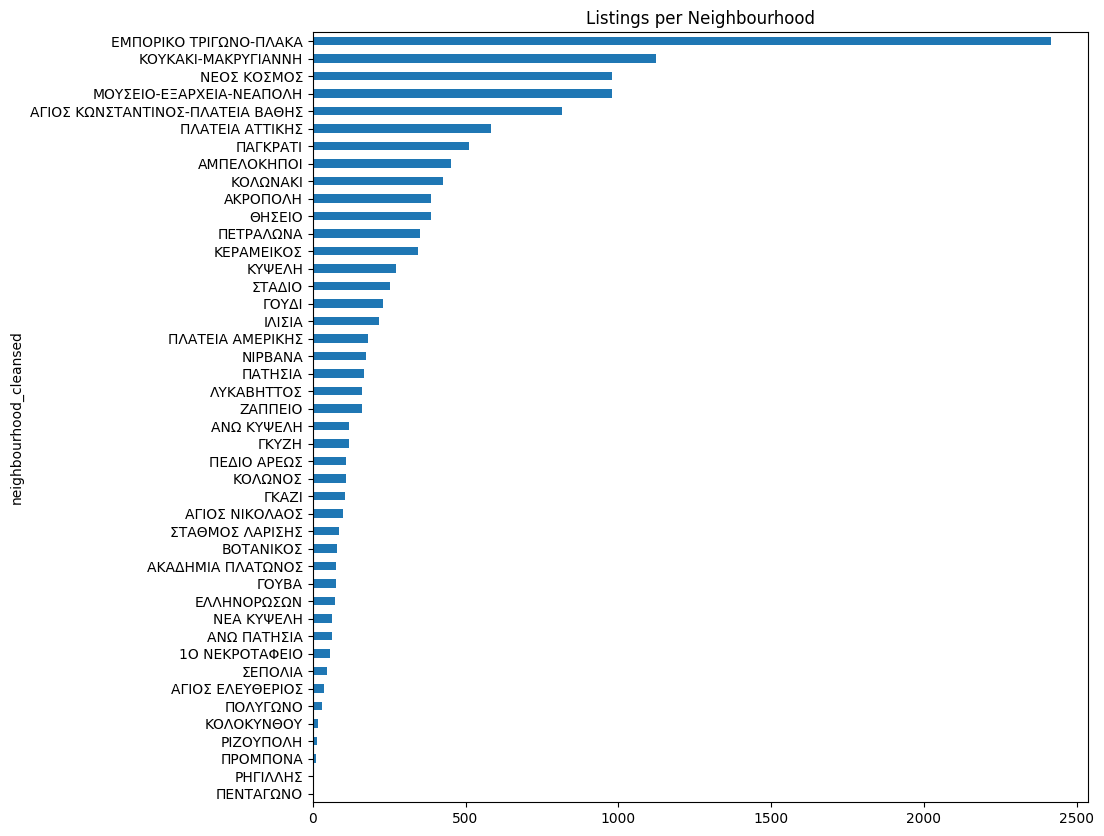

In [10]:
# reverse the order of the dataframe, and create a horizontal bar plot
listings_per_neighbourhood.iloc[::-1].plot.barh(figsize=(10, 10), legend=False,title="Listings per Neighbourhood")
plt.show()

### Second approach: Popularity means the number of reviews per neighbourhood

* We can also use the reviews dataset to determine the popularity of a neighbourhood, by counting the number of reviews per neighbourhood
* Let's see a sample of the data

In [11]:
reviews.sample(3)

listing_id                  id        date  reviewer_id reviewer_name   
199093    20398715           238158491  2018-02-25      3289750       Ioannis  \
293255    26106526           511316515  2019-08-17     66363304       Kristen   
57727      8150001  911364011333254434  2023-06-11    453573374         Ágnes   

                                                 comments  
199093  To start with, the hosts had an outstanding co...  
293255  This property exceeded our expectations. Not o...  
57727   We had an excellent time in Nestor's apartment...

* We can see that we have a listing_id column, so we can join the two datasets in order to have the neighbourhood_cleansed column as well

In [12]:
# create a new df that has the neighbourhood_cleansed column for each one of the reviews
reviews_listings = reviews.merge(listings[["id", "neighbourhood_cleansed"]], left_on="listing_id", right_on="id")
reviews_listings.sample(3)

listing_id                id_x        date  reviewer_id reviewer_name   
458657    39815178  862063628763738236  2023-04-04    111018089      Siglinde  \
503519    46086563  651173431024226942  2022-06-17    439215123          Hugo   
359120    31355685  892566085055772582  2023-05-16    473824062           יעל   

                                                 comments      id_y   
458657  Das Apartment hat uns gleich gefallen,alles wa...  39815178  \
503519  Perfect for our need, that place is good if yo...  46086563   
359120  We had a great time at the flat.<br/>Loukas wa...  31355685   

       neighbourhood_cleansed  
458657            ΑΜΠΕΛΟΚΗΠΟΙ  
503519                 ΚΥΨΕΛΗ  
359120            ΝΕΟΣ ΚΟΣΜΟΣ

* Let's do a value count on the neighbourhood_cleansed column to see the number of reviews per neighbourhood, assign it to a dataframe

In [13]:
reviews_per_neighbourhood = reviews_listings["neighbourhood_cleansed"].value_counts()
reviews_per_neighbourhood

neighbourhood_cleansed
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ              155818
ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ                  75216
ΝΕΟΣ ΚΟΣΜΟΣ                          47481
ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ     37690
ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ             37621
ΑΚΡΟΠΟΛΗ                             28135
ΘΗΣΕΙΟ                               28087
ΚΕΡΑΜΕΙΚΟΣ                           19722
ΠΑΓΚΡΑΤΙ                             19022
ΠΛΑΤΕΙΑ ΑΤΤΙΚΗΣ                      17754
ΖΑΠΠΕΙΟ                              16339
ΠΕΤΡΑΛΩΝΑ                            15995
ΑΜΠΕΛΟΚΗΠΟΙ                          15508
ΚΟΛΩΝΑΚΙ                             14437
ΣΤΑΔΙΟ                               11620
ΓΚΑΖΙ                                 8348
ΚΥΨΕΛΗ                                7540
ΙΛΙΣΙΑ                                6666
ΝΙΡΒΑΝΑ                               6259
ΓΟΥΔΙ                                 6163
ΛΥΚΑΒΗΤΤΟΣ                            5215
ΒΟΤΑΝΙΚΟΣ                             4679
ΚΟΛΩΝΟΣ                        

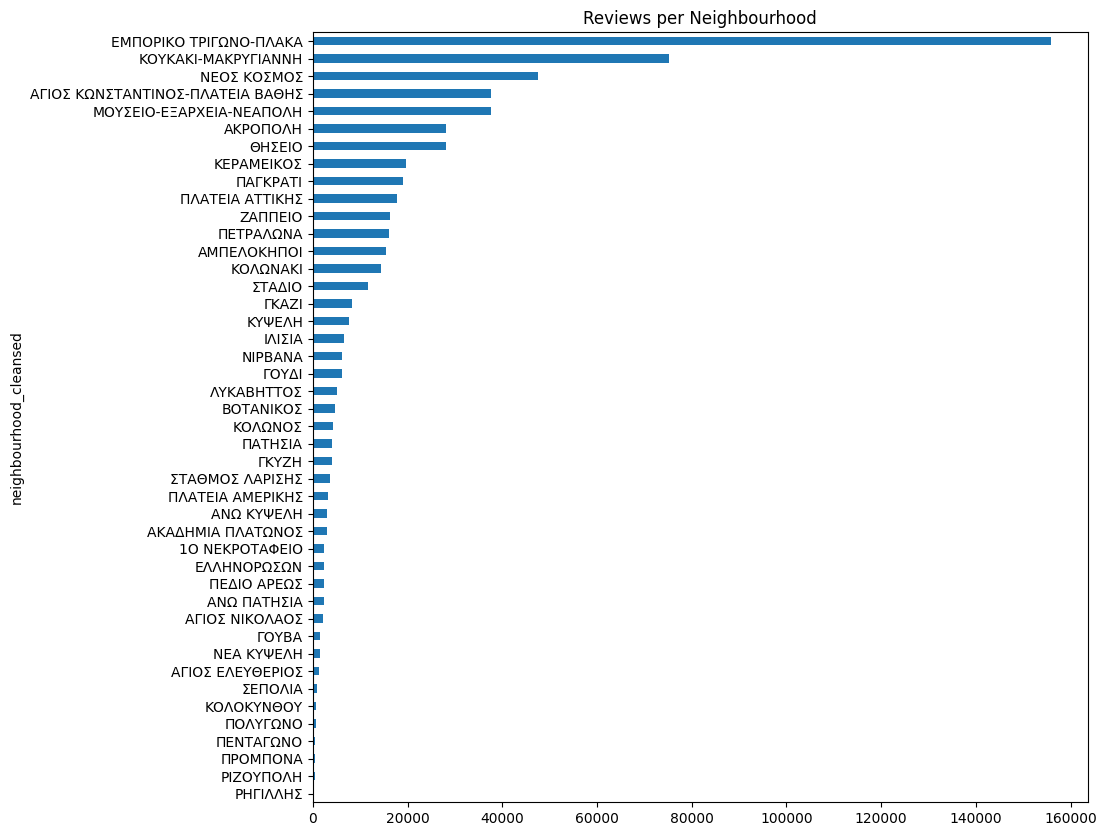

In [14]:
reviews_per_neighbourhood[::-1].plot.barh(figsize=(10, 10), legend=False,title="Reviews per Neighbourhood")
plt.show()

* As simple as that, we have the number of reviews per neighbourhood, let's visualize them
* First we will need to normalize the data so that each cell will have a percentage between 0 and 1, as reviews and listings are not the same range of values

In [15]:
# normalize the data so that each cell will have a percentage between 0 and 1
reviews_per_neighbourhood_normalized = reviews_per_neighbourhood / reviews_per_neighbourhood.sum()
listings_per_neighbourhood_normalized = listings_per_neighbourhood / listings_per_neighbourhood.sum()

In [16]:
# create a new dataframe that has the number of listings and the number of reviews per neighbourhood normalized
listings_reviews_per_neighbourhood_normalized = pd.concat([listings_per_neighbourhood_normalized, reviews_per_neighbourhood_normalized], axis=1)
listings_reviews_per_neighbourhood_normalized.columns = ["listings", "reviews"]
listings_reviews_per_neighbourhood_normalized

listings   reviews
neighbourhood_cleansed                              
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ            0.186492  0.247103
ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ               0.086607  0.119281
ΝΕΟΣ ΚΟΣΜΟΣ                       0.075646  0.075298
ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ          0.075569  0.059661
ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ  0.063064  0.059771
ΠΛΑΤΕΙΑ ΑΤΤΙΚΗΣ                   0.045002  0.028155
ΠΑΓΚΡΑΤΙ                          0.039444  0.030166
ΑΜΠΕΛΟΚΗΠΟΙ                       0.034890  0.024593
ΚΟΛΩΝΑΚΙ                          0.032806  0.022895
ΑΚΡΟΠΟΛΗ                          0.029795  0.044618
ΘΗΣΕΙΟ                            0.029795  0.044542
ΠΕΤΡΑΛΩΝΑ                         0.027171  0.025366
ΚΕΡΑΜΕΙΚΟΣ                        0.026476  0.031276
ΚΥΨΕΛΗ                            0.020919  0.011957
ΣΤΑΔΙΟ                            0.019452  0.018428
ΓΟΥΔΙ                             0.017754  0.009774
ΙΛΙΣΙΑ                            0.016673  0.010571
ΠΛΑΤΕΙΑ ΑΜΕΡΙΚΗΣ                  0.013894  0.004924
ΝΙΡΒΑΝΑ                           0.013431  0.009926
ΠΑΤΗΣΙΑ                           0.012814  0.006400
ΛΥΚΑΒΗΤΤΟΣ                        0.012505  0.008270
ΖΑΠΠΕΙΟ                           0.012428  0.025911
ΑΝΩ ΚΥΨΕΛΗ                        0.009186  0.004919
ΓΚΥΖΗ                             0.009108  0.006340
ΠΕΔΙΟ ΑΡΕΩΣ                       0.008414  0.003766
ΚΟΛΩΝΟΣ                           0.008337  0.006900
ΓΚΑΖΙ                             0.008182  0.013239
ΑΓΙΟΣ ΝΙΚΟΛΑΟΣ                    0.007642  0.003563
ΣΤΑΘΜΟΣ ΛΑΡΙΣΗΣ                   0.006561  0.005730
ΒΟΤΑΝΙΚΟΣ                         0.006175  0.007420
ΑΚΑΔΗΜΙΑ ΠΛΑΤΩΝΟΣ                 0.005866  0.004635
ΓΟΥΒΑ                             0.005789  0.002563
ΕΛΛΗΝΟΡΩΣΩΝ                       0.005635  0.003831
ΝΕΑ ΚΥΨΕΛΗ                        0.004940  0.002338
ΑΝΩ ΠΑΤΗΣΙΑ                       0.004940  0.003754
1Ο ΝΕΚΡΟΤΑΦΕΙΟ                    0.004245  0.003892
ΣΕΠΟΛΙΑ                           0.003474  0.001499
ΑΓΙΟΣ ΕΛΕΥΘΕΡΙΟΣ                  0.002933  0.002188
ΠΟΛΥΓΩΝΟ                          0.002239  0.001064
ΚΟΛΟΚΥΝΘΟΥ                        0.001235  0.001161
ΡΙΖΟΥΠΟΛΗ                         0.001003  0.000580
ΠΡΟΜΠΟΝΑ                          0.000926  0.000704
ΡΗΓΙΛΛΗΣ                          0.000386  0.000193
ΠΕΝΤΑΓΩΝΟ                         0.000154  0.000834

* It is already visible that except some minor differences, the popularity is on the same level for both approaches, let's also visualize them

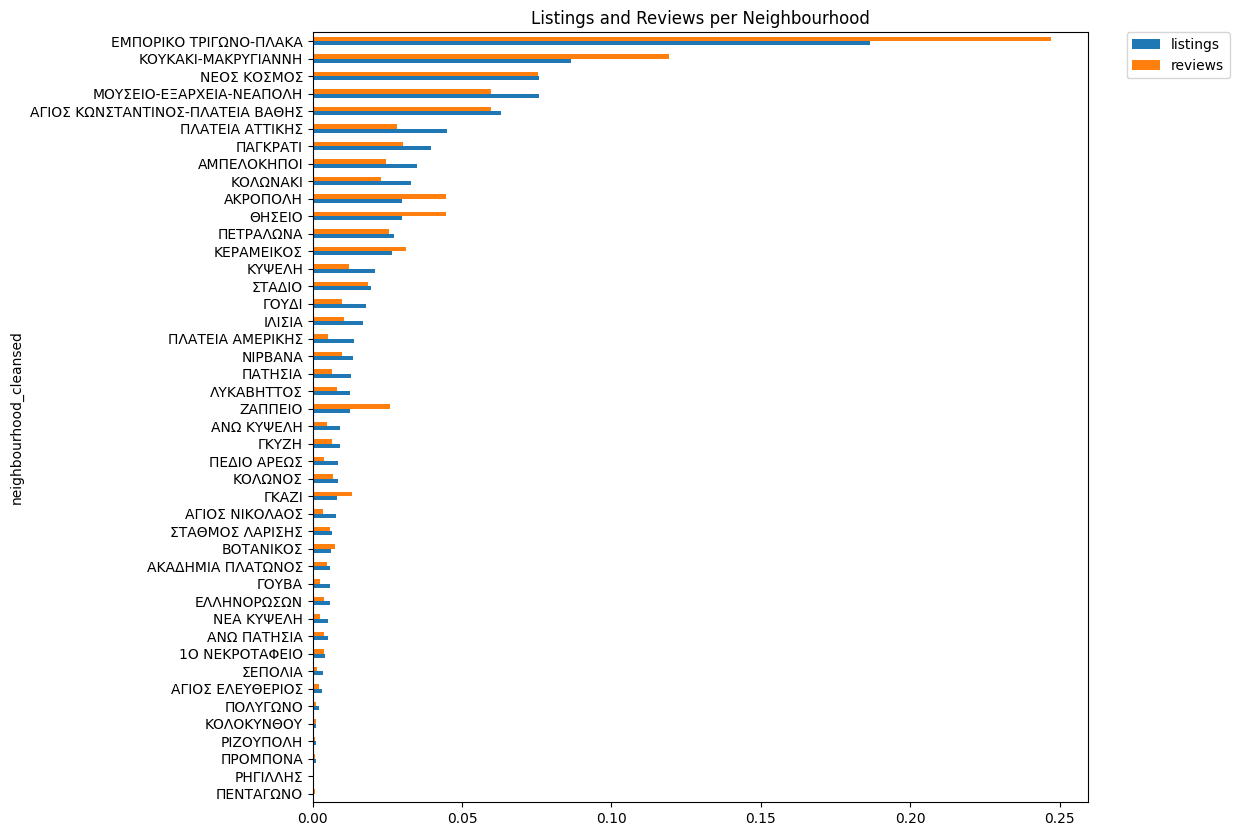

In [17]:
listings_reviews_per_neighbourhood_normalized[::-1].plot.barh(figsize=(10, 10), title="Listings and Reviews per Neighbourhood")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

* Interesting... we can see that the neighbourhoods of which their number of reviews do not follow the same pattern as the number of listings (they are mentionably higher percent-wise) are Plaka,Koukaki,Acropolis,Zappeion and others.
* Maybe in more expensive and high-value neighbourhoods, guests tend to leave more reviews? Nonetheless, the differences between the two are not that major

## Neighbourhood Prices in Descending Order

* Now let's see the prices per neighbourhood
* If we look carefully at the listings' columns above, we see that the price is there so we do not need joins again.
* Are there any outliers though?

In [18]:
listings["price"].describe()

count      12955
unique       507
top       $50.00
freq         414
Name: price, dtype: object

* Interesting, we do not get the statistics we expected, maybe because of the dollar data type? Let's convert it to float and try again

In [19]:
listings["price"] = listings["price"].str.replace("$", "").str.replace(",", "").astype(float)

In [20]:
listings["price"].describe()

count    12955.000000
mean       110.458587
std        738.185656
min         10.000000
25%         50.000000
50%         71.000000
75%        113.000000
max      80275.000000
Name: price, dtype: float64

* The max value seems a bit high, let's see the distribution of the prices

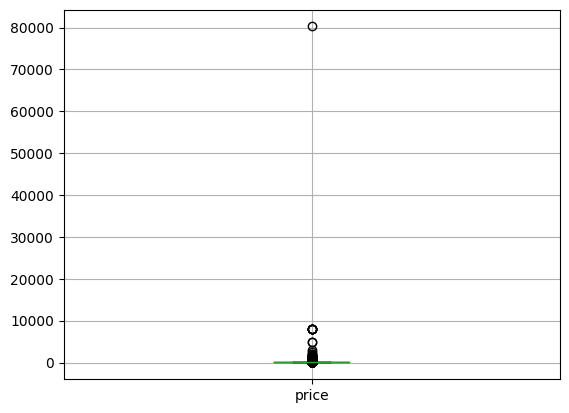

In [21]:
listings.boxplot(column="price")
plt.show()

* We can see that there are some outliers, everything below the 10000 dollar price point seems reasonable, so let's filter the dataframe to see the prices above 10000 dollars and below 0

In [22]:
listings[(listings["price"] > 10000) | (listings["price"] < 0)][["id", "price","neighbourhood_cleansed"]]

id    price    neighbourhood_cleansed
3641  32463338  80275.0  ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ

* Unless a palace is listed on AirBnB, the price of 80000 seems unreasonable, so let's filter it out and create another boxplot as well as the basic descriptive statistics

In [23]:
listings_normal_prices = listings[listings["price"] < 80000]
listings_normal_prices["price"].describe()

count    12954.000000
mean       104.270187
std        220.891911
min         10.000000
25%         50.000000
50%         71.000000
75%        113.000000
max       8000.000000
Name: price, dtype: float64

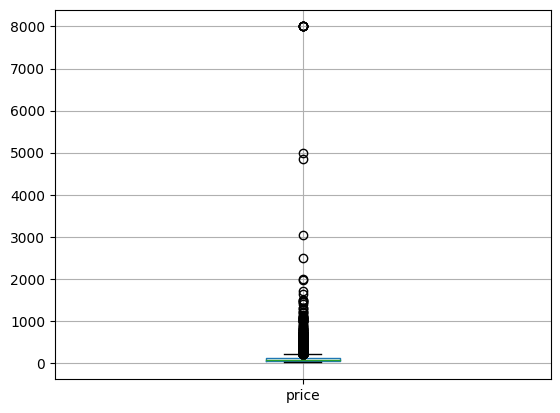

In [24]:
listings_normal_prices.boxplot(column="price")
plt.show()

* We see that the max value, mean and std have been reduced significantly just by removing a single outlier
* But we still see that there are still some outliers, we could use z-score or IQR to remove them, but let's see some screenshots of the listings on AirBnB to see the range of prices.
* Since we have access to airbnb data for athens, let's check out what is the price range for a single night in a hotel in Athens


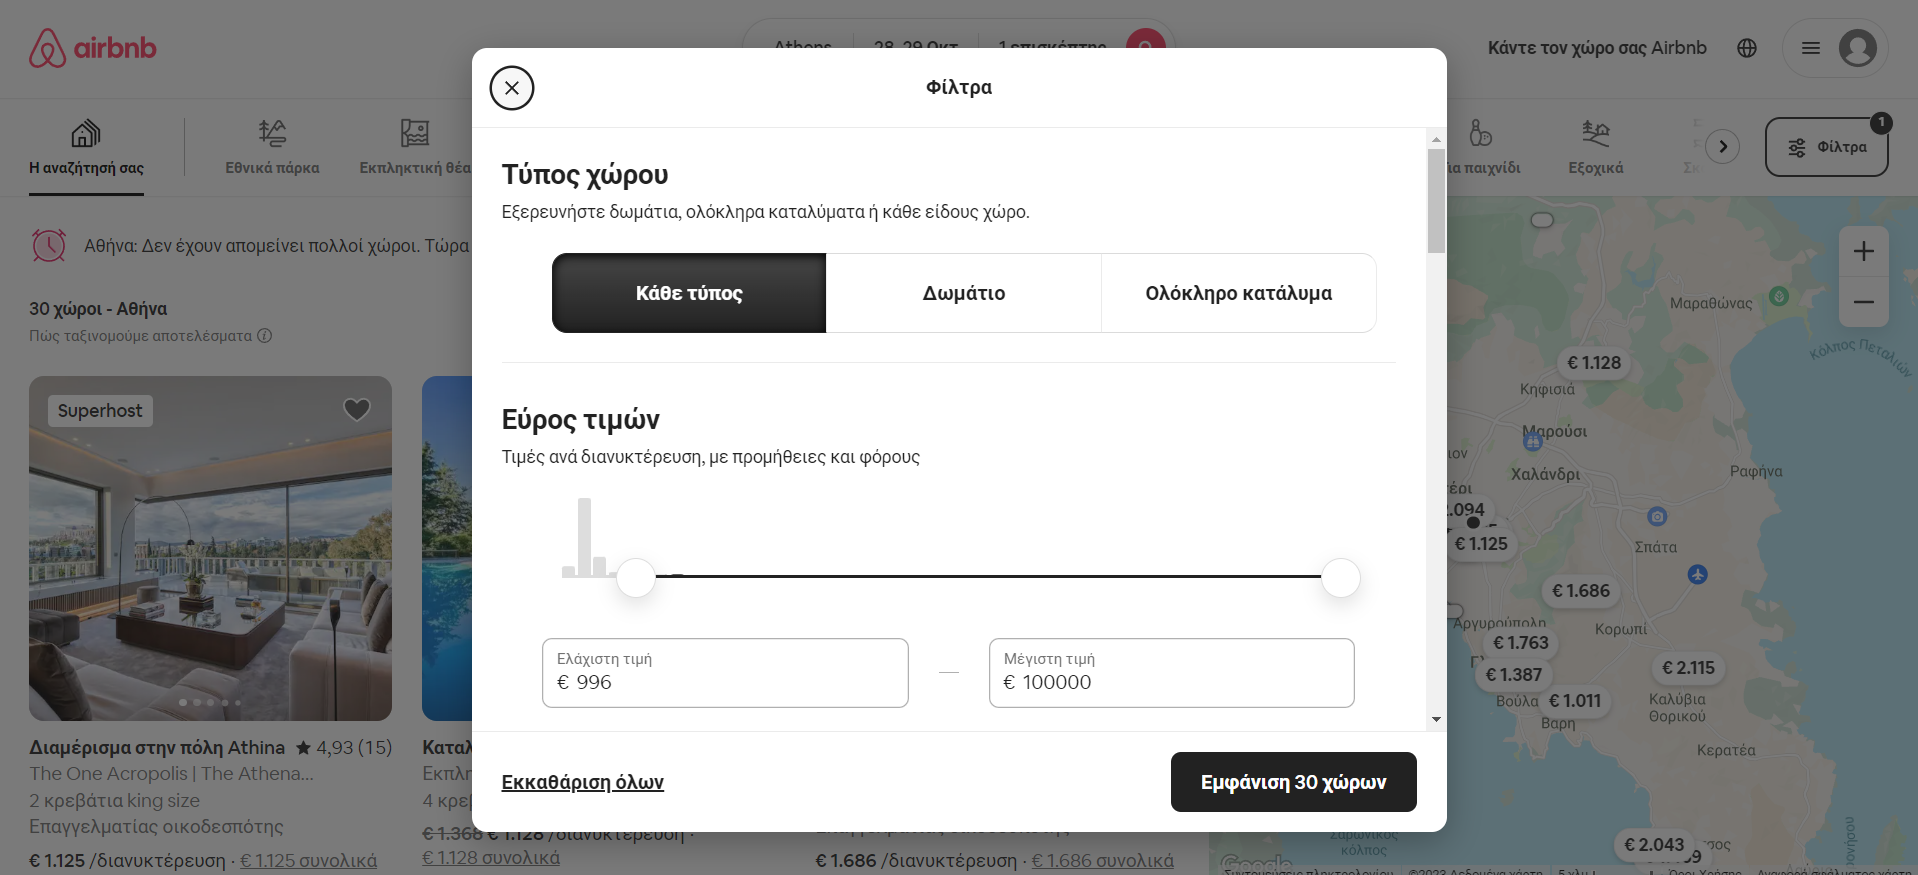

In [25]:
from IPython.display import Image
Image(filename='images/expensive_airbnbs_athens.png')

* It seems real that there are plenty of listings with prices close or above the 1000 euro-range (30)
* Let's see the most expensive listing in Athens

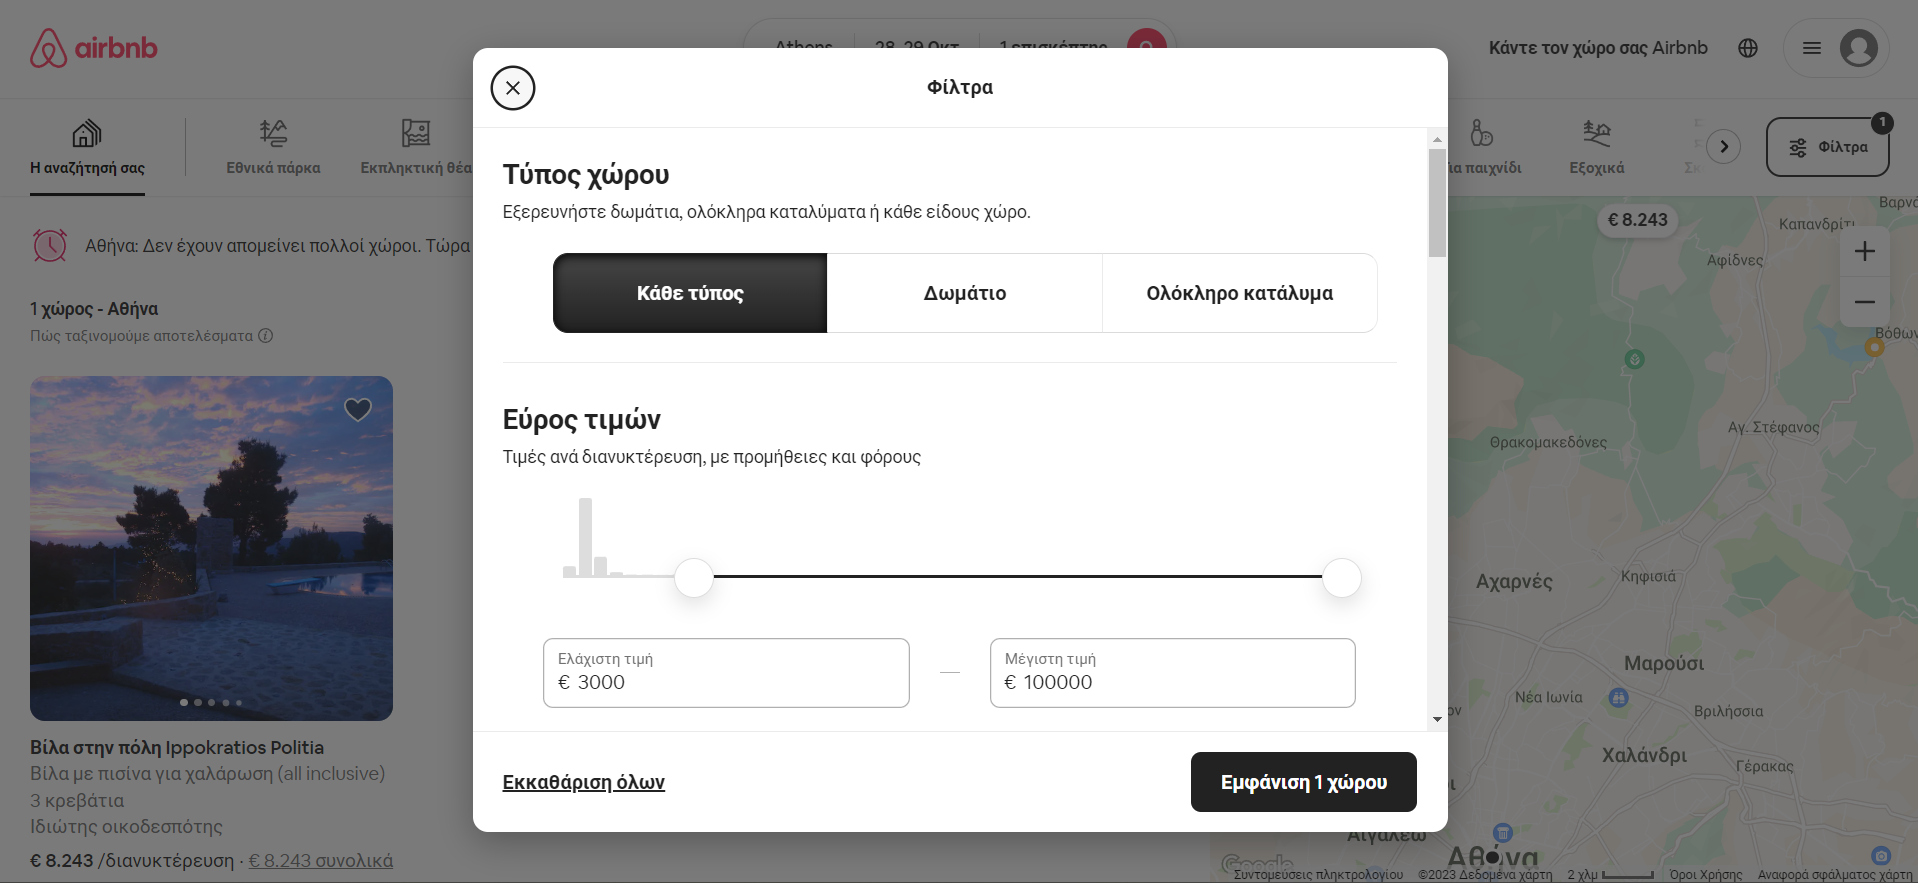

In [26]:
Image(filename='images/most_expensive_airbnb.png')

* Indeed, the most expensive listing is a whole villa costing a bit over 8000 euros, so the data make sense
* But statistically they remain outliers, so we will use IQR to remove them since it is one of the most common methods to remove outliers.
* It is important to mention that we could use other methods z-score as well.
* For further information regarding IQR, you can check out: https://en.wikipedia.org/wiki/Interquartile_range, https://towardsdatascience.com/why-1-5-in-iqr-method-of-outlier-detection-5d07fdc82097

In [27]:
# find the IQR
Q1 = listings_normal_prices["price"].quantile(0.25)
Q3 = listings_normal_prices["price"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

63.0


In [28]:
# remove the outliers
listings_normal_prices = listings_normal_prices[~((listings_normal_prices["price"] < (Q1 - 1.5 * IQR)) | (listings_normal_prices["price"] > (Q3 + 1.5 * IQR)))]

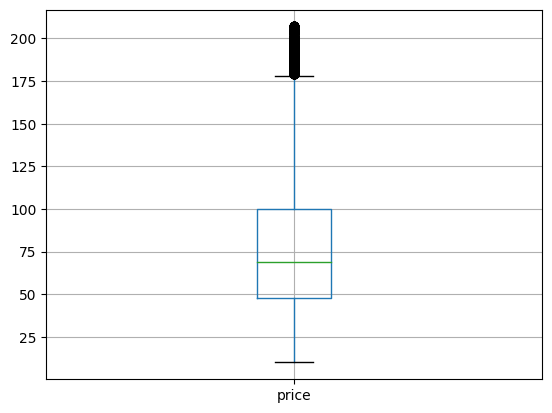

In [29]:
listings_normal_prices.boxplot(column="price")
plt.show()

* We are on a much better spot now, let's see the prices per neighbourhood with all the metrics

In [30]:
listings_per_neighbourhood_prices = listings_normal_prices.groupby("neighbourhood_cleansed").agg({"price": ["median", "mean", "std", "count"]}).sort_values(by=("price", "median"), ascending=False)
listings_per_neighbourhood_prices.columns = ["median", "mean", "standard deviation", "number of listings"]

In [31]:
listings_per_neighbourhood_prices

median        mean  standard deviation   
neighbourhood_cleansed                                                     
ΖΑΠΠΕΙΟ                             96.0  101.838710           47.141439  \
ΡΗΓΙΛΛΗΣ                            96.0  109.750000           49.735132   
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ              95.0  101.299182           42.247004   
ΚΟΛΩΝΑΚΙ                            90.0   98.102981           41.661227   
ΑΚΡΟΠΟΛΗ                            89.0   99.324324           44.838632   
ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ                 86.0   94.471866           41.167791   
ΚΕΡΑΜΕΙΚΟΣ                          83.0   92.196667           42.181698   
ΘΗΣΕΙΟ                              81.0   92.005970           40.274432   
ΛΥΚΑΒΗΤΤΟΣ                          71.5   83.358108           39.953376   
ΓΚΑΖΙ                               70.0   83.715686           42.057805   
ΙΛΙΣΙΑ                              70.0   80.028846           38.565950   
ΣΤΑΔΙΟ                              67.0   74.166667           34.212316   
ΝΕΟΣ ΚΟΣΜΟΣ                         66.0   75.757219           37.142643   
ΠΑΓΚΡΑΤΙ                            66.0   72.535211           35.186532   
ΠΕΤΡΑΛΩΝΑ                           64.5   70.922156           30.819243   
ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ            64.0   77.080559           42.427661   
1Ο ΝΕΚΡΟΤΑΦΕΙΟ                      60.0   74.580000           40.285253   
ΒΟΤΑΝΙΚΟΣ                           60.0   72.285714           37.994756   
ΕΛΛΗΝΟΡΩΣΩΝ                         59.0   62.014925           24.946909   
ΓΟΥΔΙ                               58.0   68.039301           34.430240   
ΑΜΠΕΛΟΚΗΠΟΙ                         57.5   63.995516           29.405495   
ΠΡΟΜΠΟΝΑ                            57.0   60.833333           27.511430   
ΓΟΥΒΑ                               56.0   60.876712           26.407041   
ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ    56.0   67.254130           34.311015   
ΣΕΠΟΛΙΑ                             55.0   55.318182           23.369402   
ΠΕΔΙΟ ΑΡΕΩΣ                         55.0   64.572816           38.215745   
ΚΥΨΕΛΗ                              50.0   55.647727           28.243660   
ΑΚΑΔΗΜΙΑ ΠΛΑΤΩΝΟΣ                   50.0   58.486486           30.663102   
ΝΕΑ ΚΥΨΕΛΗ                          50.0   56.453125           28.871873   
ΣΤΑΘΜΟΣ ΛΑΡΙΣΗΣ                     48.0   53.578313           27.031653   
ΑΝΩ ΠΑΤΗΣΙΑ                         48.0   56.078125           29.493774   
ΠΛΑΤΕΙΑ ΑΤΤΙΚΗΣ                     47.0   55.803853           31.397788   
ΚΟΛΩΝΟΣ                             47.0   51.888889           21.263955   
ΠΕΝΤΑΓΩΝΟ                           46.0   46.000000            1.414214   
ΠΟΛΥΓΩΝΟ                            45.0   54.310345           26.467100   
ΑΓΙΟΣ ΝΙΚΟΛΑΟΣ                      45.0   49.556701           20.722356   
ΠΑΤΗΣΙΑ                             44.0   49.276074           25.824261   
ΠΛΑΤΕΙΑ ΑΜΕΡΙΚΗΣ                    44.0   49.719101           26.845020   
ΓΚΥΖΗ                               44.0   48.632479           20.685493   
ΡΙΖΟΥΠΟΛΗ                           44.0   52.538462           22.096815   
ΚΟΛΟΚΥΝΘΟΥ                          43.0   43.937500            9.532182   
ΝΙΡΒΑΝΑ                             42.0   51.161850           30.724533   
ΑΝΩ ΚΥΨΕΛΗ                          42.0   45.932773           23.316078   
ΑΓΙΟΣ ΕΛΕΥΘΕΡΙΟΣ                    41.5   43.736842           17.408734   

                                  number of listings  
neighbourhood_cleansed                                
ΖΑΠΠΕΙΟ                                          124  
ΡΗΓΙΛΛΗΣ                                           4  
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ                          2079  
ΚΟΛΩΝΑΚΙ                                         369  
ΑΚΡΟΠΟΛΗ                                         333  
ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ                             1013  
ΚΕΡΑΜΕΙΚΟΣ                                       300  
ΘΗΣΕΙΟ                                    

## Availability per Day

* Let's see the availability per day, first by looking at the calendar dataset

In [32]:
calendar.sample(3)

listing_id        date available   price adjusted_price   
1172429            30232733  2023-10-21         f  $95.00         $95.00  \
3808221  846093742268150504  2024-02-25         t  $53.00         $53.00   
2103617            45548989  2024-01-02         f  $69.00         $69.00   

         minimum_nights  maximum_nights  
1172429               2            1125  
3808221               3             365  
2103617               3            1125

In [33]:
calendar.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

* Seems like the columns available,date and listing_id will be used, let's see their values

In [34]:
calendar[["listing_id","date","available"]].sample(3)

listing_id        date available
3414896  743449308051208022  2024-07-19         t
2443396            51676205  2023-11-27         t
4009991  877607544110494612  2023-12-12         t

In [35]:
#check if calendar has the same listings as the listings dataset
listings_ids_calendar = calendar["listing_id"].unique()
listings_ids_listings = listings["id"].unique()
np.all(np.isin(listings_ids_listings,listings_ids_calendar))

True

* Seems like the values are either t or f, probably meaning true or false, let's take a look also on the listings dataset to see if there are similar columns

In [36]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [37]:
listings.filter(regex="availability").sample(3)

has_availability  availability_30  availability_60  availability_90   
8309                 t               18               35               35  \
4677                 t                2               24               54   
10897                t                2                6               36   

       availability_365  
8309                207  
4677                144  
10897               110

* Seems like we have availability columns but no date ones, which makes sense to be only in the calendar dataset, so we will not need a join again.

In [38]:
availability_per_day = calendar[calendar["available"] == "t"].groupby("date").count().sort_values(by="date", ascending=True)[["listing_id"]].rename(columns={"listing_id": "total_listings"})
# convert the index to datetime, in order to plot it in a more readable way
availability_per_day.index = pd.to_datetime(availability_per_day.index)
availability_per_day

total_listings
date                      
2023-09-21             540
2023-09-22             982
2023-09-23            1475
2023-09-24            2495
2023-09-25            3194
...                    ...
2024-09-15            7532
2024-09-16            7535
2024-09-17            7532
2024-09-18            7537
2024-09-19            7555

[365 rows x 1 columns]

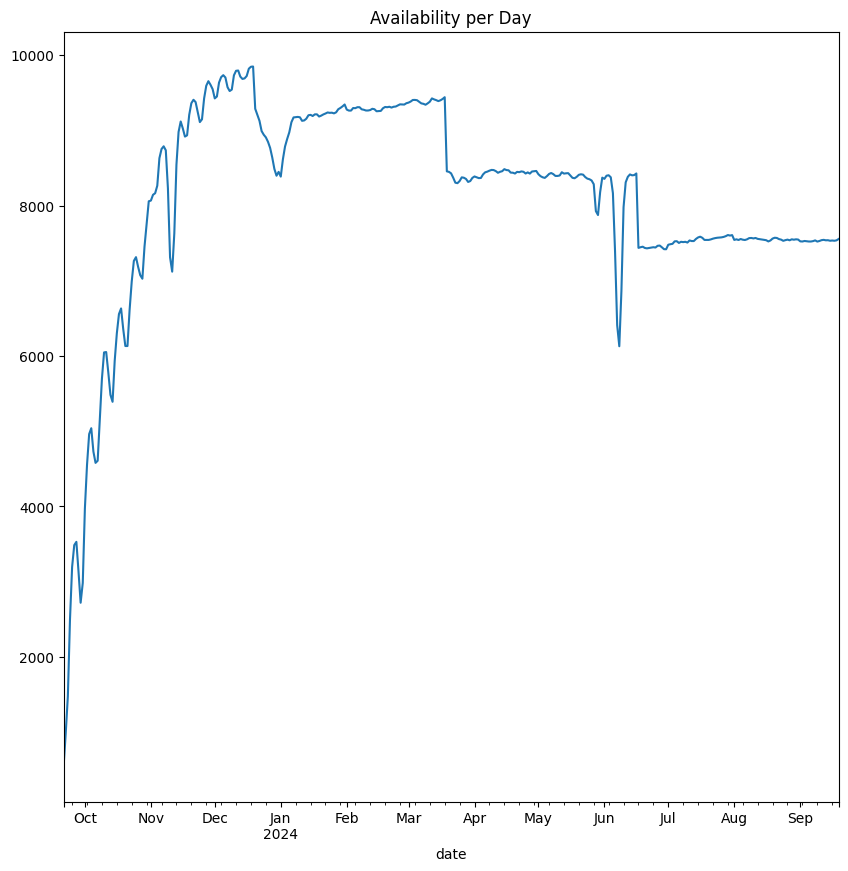

In [39]:
availability_per_day.plot(figsize=(10, 10), legend=False,title="Availability per Day")
plt.show()

* The graph seems correct, as we can see that the availability is drops in the summer months, which is the high season for tourism in Greece, and around Christmas too.

## Reviews, Occupacy per Listing, Average Income

* Let's see the reviews dataset

In [40]:
reviews.sample(3)

listing_id                  id        date  reviewer_id   
234851            22966639           479542495  2019-07-01      4111792  \
584933  645411830461507445  680158790186256542  2022-07-27     48390660   
528767            50493829  644655670553985754  2022-06-08     33182584   

       reviewer_name                                           comments  
234851        George  This is a cozy space, very clean and quiet in ...  
584933     Dimitrios  Amazing apartment in the heart of Athens. Grea...  
528767          Mark  A lovely apartment in the centre of Athens. Gr...

In [41]:
reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

* Seems like again we will not need joins. Just group by listing_id and get the count of reviews, ascending, keeping only one column and naming it total_reviews

In [42]:
reviews_per_listing = reviews.groupby("listing_id").count().sort_values(by="id", ascending=False)[["id"]].rename(columns={"id": "total_reviews"})

In [43]:
reviews_per_listing

total_reviews
listing_id                       
1177492                       865
3431705                       856
13553080                      778
14583913                      764
5025556                       731
...                           ...
40811117                        1
40819345                        1
841346347093410091              1
31396772                        1
979596287508787842              1

[10999 rows x 1 columns]

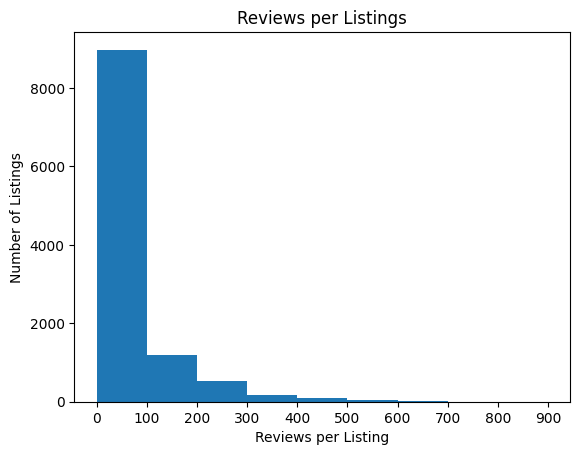

In [44]:
min = 0
max = reviews_per_listing["total_reviews"].max()
plt.hist(reviews_per_listing["total_reviews"], bins=range(min, max + 100, 100))
plt.title('Reviews per Listings')
plt.xlabel("Reviews per Listing")
plt.ylabel("Number of Listings")
plt.xticks(range(min, max + 100, 100))
plt.show()

* We see that most listings have less than 100 reviews, the ones with a lot of reviews are not that many, let's see the same graph with a log scale to see the small bars better.

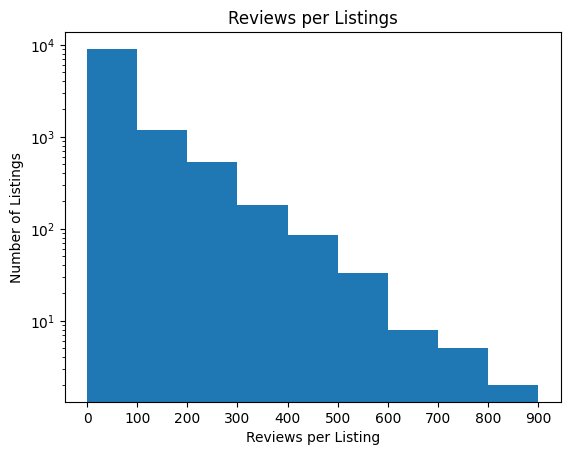

In [45]:
plt.hist(reviews_per_listing["total_reviews"], bins=range(min, max + 100, 100))
plt.title('Reviews per Listings')
plt.xlabel("Reviews per Listing")
plt.ylabel("Number of Listings")
plt.yscale("log")
plt.xticks(range(min, max + 100, 100))
plt.show()

* Let's move on finding the average occupacy per listing per month, assuming that half of the bookings result in reviews.
* Let's start by seeing the columns in listings that have to do with reviews

In [46]:
listings.filter(regex="review").sample(3)

number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d   
1805                170                     39                       5  \
3865                 77                      6                       0   
2597                 27                      3                       0   

     first_review last_review  review_scores_rating  review_scores_accuracy   
1805   2018-03-07  2023-09-17                  4.94                    4.96  \
3865   2019-05-17  2023-03-16                  4.73                    4.84   
2597   2018-07-29  2023-08-09                  5.00                    4.89   

      review_scores_cleanliness  review_scores_checkin   
1805                       4.92                   4.98  \
3865                       4.82                   4.61   
2597                       5.00                   5.00   

      review_scores_communication  review_scores_location   
1805                         4.99                    4.91  \
3865                         4.73                    4.40   
2597                         5.00                    4.89   

      review_scores_value  reviews_per_month  
1805                 4.94               2.52  
3865                 4.82               1.45  
2597                 4.81               0.43

* Seems like we have a column named reviews_per_month, which probably contains historic values
* As a result we can find the average reviews per month, either by analyzing the current data from the reviews dataset, or by using the historic data from the listings dataset.
* Let's start by using the current data from the reviews dataset and then compare the results with the historic data from the listings dataset.

In [47]:
#convert the date column to datetime
reviews["date"] = pd.to_datetime(reviews["date"])

In [48]:
reviews_per_listing_per_month = reviews.groupby("listing_id").count().sort_values(by="id", ascending=False)[["id"]].rename(columns={"id": "total_reviews"})
reviews_per_listing_per_month.sample(3)

total_reviews
listing_id                       
15727101                        1
41346290                       97
823902303974469056             12

* Let's see what would happen if we did not remove the outliers

In [49]:
# assume that half of the bookings result in reviews, so multiply by 2, then divide by 12 to get the average per month
average_bookings_per_listing_per_month = reviews_per_listing_per_month["total_reviews"].mean() * 2 / 12
average_bookings_per_listing_per_month

9.555080764918022

* Seems a bit high...
* Let's also remove the outliers

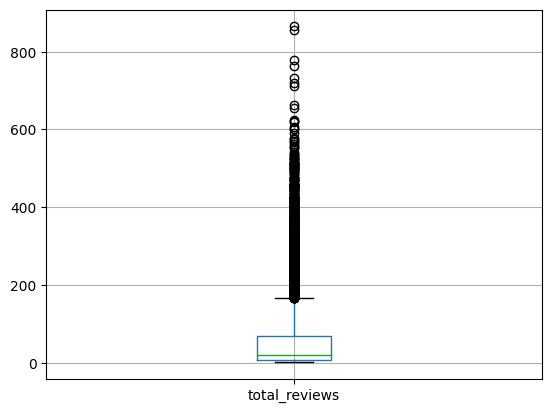

In [50]:
reviews_per_listing_per_month.boxplot(column="total_reviews")
plt.show()

In [51]:
# use the IQR method
Q1 = reviews_per_listing_per_month["total_reviews"].quantile(0.25)
Q3 = reviews_per_listing_per_month["total_reviews"].quantile(0.75)
IQR = Q3 - Q1

In [52]:
reviews_per_listing_per_month = reviews_per_listing_per_month[~((reviews_per_listing_per_month["total_reviews"] < (Q1 - 1.5 * IQR)) |(reviews_per_listing_per_month["total_reviews"] > (Q3 + 1.5 * IQR)))]

In [53]:
average_bookings_per_listing_per_month = reviews_per_listing_per_month["total_reviews"].mean() * 2 / 12
average_bookings_per_listing_per_month

5.569475277497477

* So, with the first approach, we can see that the average occupacy per listing per month is approximately 5.57, after cleaning the outlier review counts.
* Now let's try the second approach, using the historic data from the listings dataset

In [54]:
listings_reviews_per_month = listings[["id", "reviews_per_month"]]

# clean the outliers of reviews per month
Q1 = listings_reviews_per_month["reviews_per_month"].quantile(0.25)
Q3 = listings_reviews_per_month["reviews_per_month"].quantile(0.75)
IQR = Q3 - Q1

In [55]:
listings_reviews_per_month = listings_reviews_per_month[~((listings_reviews_per_month["reviews_per_month"] < (Q1 - 1.5 * IQR)) |(listings_reviews_per_month["reviews_per_month"] > (Q3 + 1.5 * IQR)))]

In [56]:
# use the listing dataset to get the reviews_per_month column
reviews_per_month = listings_reviews_per_month[["id", "reviews_per_month"]] * 2
reviews_per_month["reviews_per_month"].mean()

3.1546415736712685

* Interestingly, the second historic approach gives us an occupacy of approximately 3.15, which is almost half of the first approach.
* Why? One thought is that the occupacy has increased over the years, so the historic data do not represent the current situation.
* Another thought is that the reviews_per_month column is not accurate, and it is not the actual number of reviews per month. Will have to ask the owners of the dataset.
* What we can do right now is to search in forums or in the AirBnB website for further information. In most forums, the answers are around 20+ days a month.
* If we suppose that each booking is for a three night stay, the first approach gives us roughly 17 days a month, through cleaning the ones with a lot of reviews, and the second one gives us around 9.5 days a month. Based only on the forum responses, the second approach seems to be more sensible.
* For instance, check out: https://lovethemaldives.com/faq/how-often-are-airbnbs-rented-out/

* Let's move on to the average income per listing per month, using the first approach about the occupacy
* We will use the average occupacy per listing per month, and the listings_normal_prices that we calculated earlier, to find the average income per listing per month

In [57]:
# multiply by 3 as we assume that each booking is for a three night stay
average_income_per_listing_per_month = average_bookings_per_listing_per_month * listings_normal_prices["price"].mean() * 3
average_income_per_listing_per_month

1313.094782229275

* The income may seem high, for greek standards, do not forget that we have not taken into account fees, taxes, operational costs, etc., plus the fact that we are talking about listings mainly in the center of Athens.
* Check out https://www.kathimerini.gr/economy/business/1036937/esoda-1-500-eyro-ton-mina-apo-tin-airbnb/

## Listings per Room Type

* Show the number of listings per room type, in absolute numbers, and also in percentages (the percentage of listings for each particular room type). Then, show the number of listings per neighrbourhood and room type
* Let's see the room types first

In [58]:
listings.filter(regex="room").sample(3)

room_type  bathrooms bathrooms_text  bedrooms   
6324  Entire home/apt        NaN         1 bath       1.0  \
491   Entire home/apt        NaN         1 bath       1.0   
5130  Entire home/apt        NaN         1 bath       1.0   

      calculated_host_listings_count_private_rooms   
6324                                             0  \
491                                              0   
5130                                             0   

      calculated_host_listings_count_shared_rooms  
6324                                            0  
491                                             0  
5130                                            0

* Seems like we have the room_type column, let's see its values

In [59]:
listings["room_type"].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [60]:
listings_per_room_type = listings.groupby("room_type").count().sort_values(by="id", ascending=True)[["id"]].rename(columns={"id": "total_listings"})
listings_per_room_type

total_listings
room_type                      
Shared room                  85
Hotel room                  105
Private room               1113
Entire home/apt           11652

* Let's see the number of listings per room type as absolute numbers.
* We will use a horizontal bar chart, since it is easier to read the room types

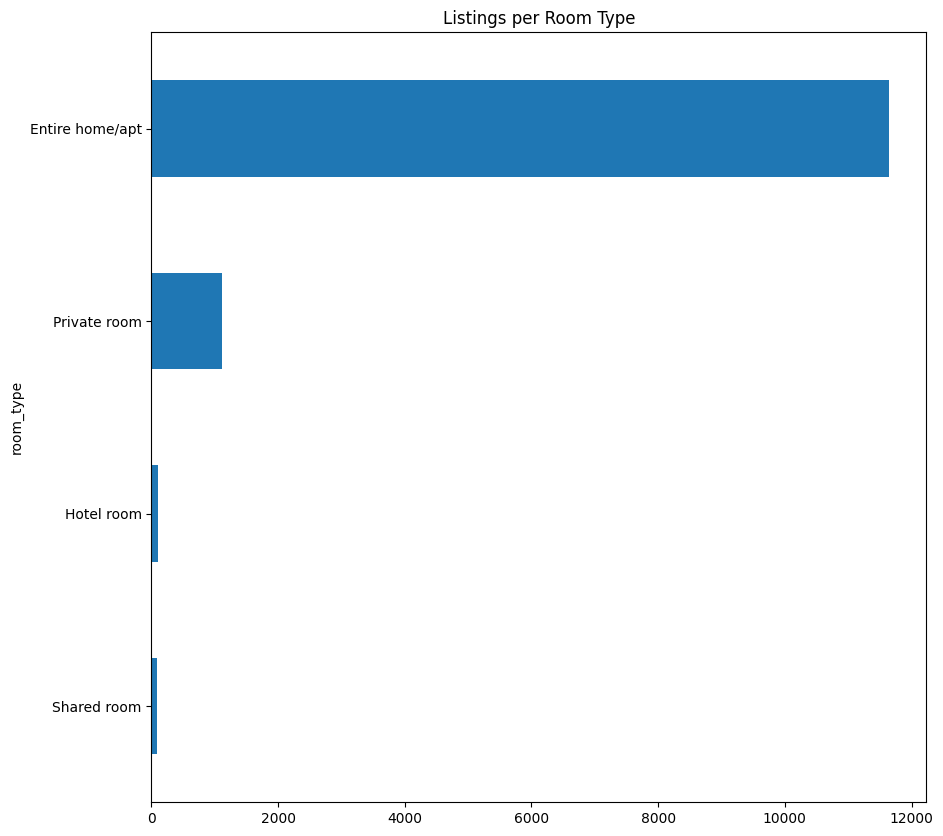

In [61]:
listings_per_room_type.plot.barh(figsize=(10, 10), legend=False,title="Listings per Room Type")
plt.show()

* For the percentage of listings per room type, we will use a pie chart that is better suited for percentages

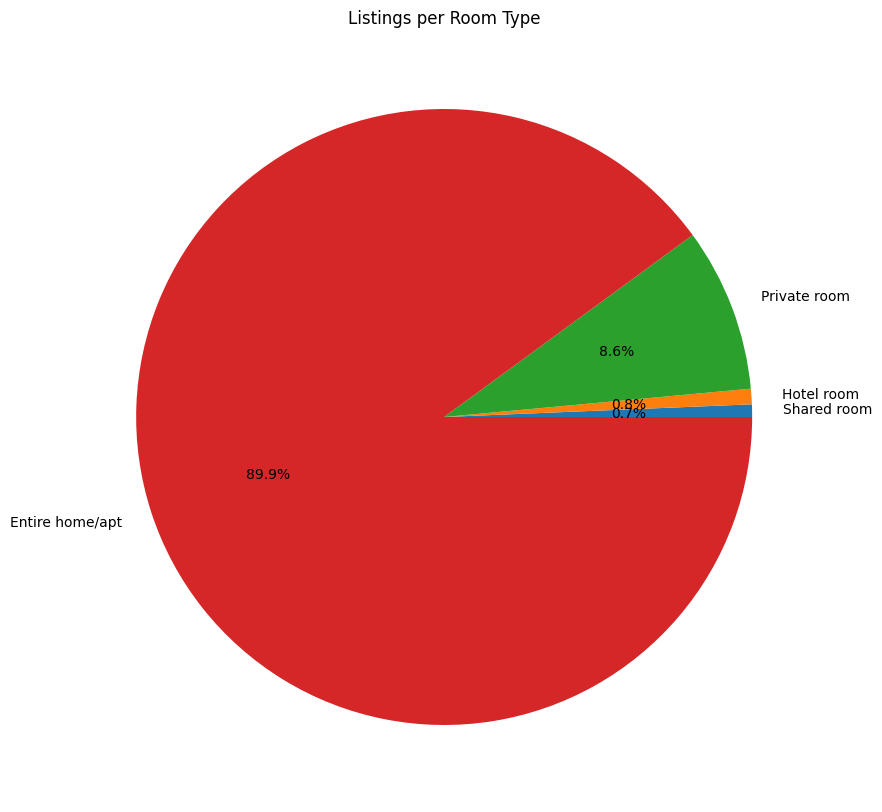

In [62]:
listings_per_room_type["total_listings"].plot.pie(figsize=(10, 10), autopct='%1.1f%%', labels=listings_per_room_type.index,title="Listings per Room Type")
plt.ylabel("")
plt.show()

* Let's see the number of listings per neighbourhood and room type

In [63]:
listings_per_neighbourhood_room_type = listings.groupby(["neighbourhood_cleansed", "room_type"]).count().sort_values(by="id", ascending=True)[["id"]].rename(columns={"id": "total_listings"})
listings_per_neighbourhood_room_type.sample(3)

total_listings
neighbourhood_cleansed           room_type                      
ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ Hotel room                    4
ΓΟΥΔΙ                            Private room                 18
ΑΚΑΔΗΜΙΑ ΠΛΑΤΩΝΟΣ                Entire home/apt              74

* Again we will use a horizontal bar chart, since it is easier to read the neighbourhoods and compare different types of rooms

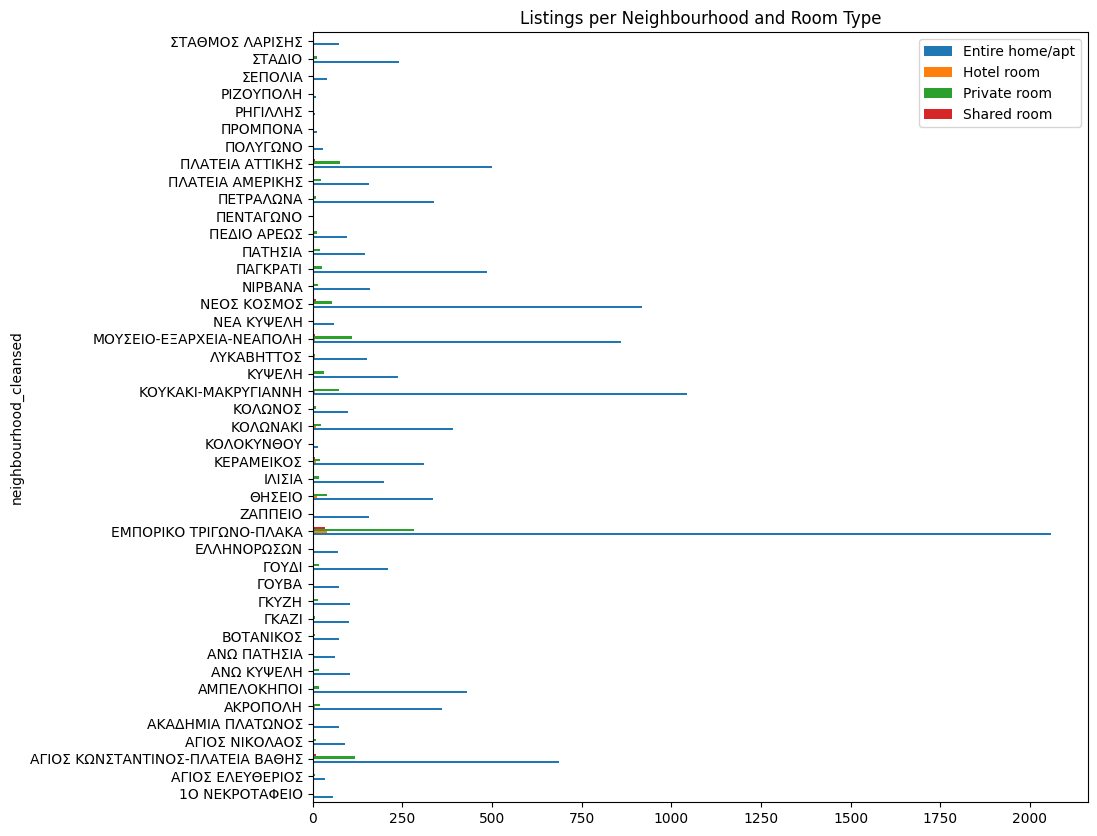

In [64]:
listings_per_neighbourhood_room_type.unstack().plot.barh(figsize=(10, 10), legend=False,title="Listings per Neighbourhood and Room Type")
plt.legend(listings_per_neighbourhood_room_type.index.levels[1])
plt.show()

## Prices per Day

* Let's check the prices, they are in both the calendar and the listings dataset as we saw earlier, we will prefer the calendar data since the price could have changed over time and we have the date column there too.
* But if we take a look at the columns we can see price and adjusted price

In [65]:
calendar.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

* We see that there is also an adjusted price column. The inside AirBnB documentation does not explain the difference, so let's do the analysis for both

In [66]:
# convert the columns to float
calendar["price"] = calendar["price"].str.replace("$", "").str.replace(",", "").astype(float)
calendar["adjusted_price"] = calendar["adjusted_price"].str.replace("$", "").str.replace(",", "").astype(float)
# and the date column to datetime
calendar["date"] = pd.to_datetime(calendar["date"])

In [67]:
calendar_prices = calendar[["date","price"]]
calendar_prices.describe()

date         price
count                        4728229  4.728229e+06
mean   2024-03-21 00:01:00.064095744  1.418523e+02
min              2023-09-21 00:00:00  0.000000e+00
25%              2023-12-21 00:00:00  5.000000e+01
50%              2024-03-21 00:00:00  7.100000e+01
75%              2024-06-20 00:00:00  1.170000e+02
max              2024-09-19 00:00:00  8.514000e+04
std                              NaN  7.994942e+02

* The data seem close.
* Since we have not cleaned the calendar dataset, we will have to do it now.

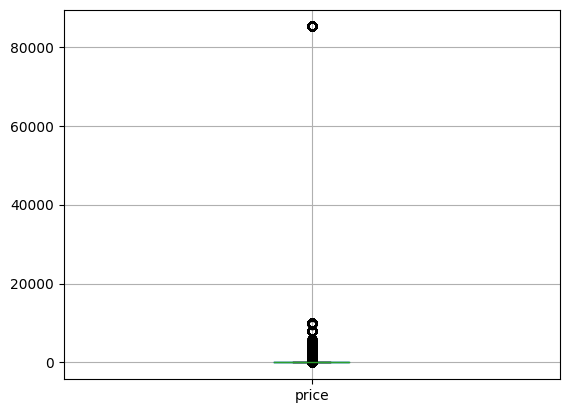

In [68]:
# remove outliers with a boxplot and then IQR
calendar_prices.boxplot(column="price")
plt.show()

* We see that there are some outliers as before, let's remove them

In [69]:
q1 = calendar_prices["price"].quantile(0.25)
q3 = calendar_prices["price"].quantile(0.75)
iqr = q3 - q1
calendar_prices = calendar_prices[(calendar_prices["price"] > (q1 - 1.5 * iqr)) & (calendar_prices["price"] < (q3 + 1.5 * iqr))]
calendar_prices.describe()

date         price
count                        4378825  4.378825e+06
mean   2024-03-19 15:44:57.890596352  7.975505e+01
min              2023-09-21 00:00:00  0.000000e+00
25%              2023-12-19 00:00:00  4.900000e+01
50%              2024-03-18 00:00:00  7.000000e+01
75%              2024-06-19 00:00:00  1.000000e+02
max              2024-09-19 00:00:00  2.170000e+02
std                              NaN  4.283624e+01

* Much better, now do the same for the adjusted price

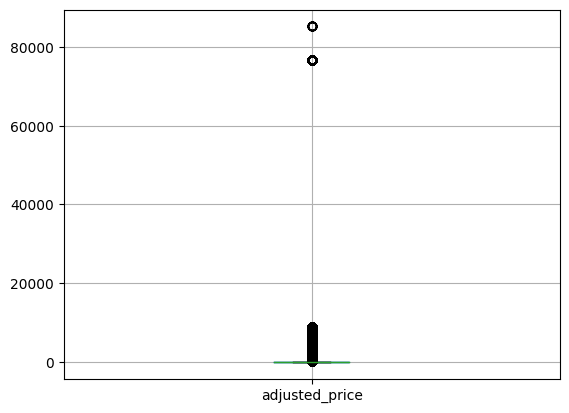

In [70]:
calendar_adjusted_prices = calendar[["date","adjusted_price"]]
calendar_adjusted_prices.boxplot(column="adjusted_price")
plt.show()

In [71]:
q1 = calendar_adjusted_prices["adjusted_price"].quantile(0.25)
q3 = calendar_adjusted_prices["adjusted_price"].quantile(0.75)
iqr = q3 - q1
calendar_adjusted_prices = calendar_adjusted_prices[(calendar_adjusted_prices["adjusted_price"] > (q1 - 1.5 * iqr)) & (calendar_adjusted_prices["adjusted_price"] < (q3 + 1.5 * iqr))]
calendar_adjusted_prices.describe()

date  adjusted_price
count                        4381846    4.381846e+06
mean   2024-03-19 15:12:33.635795456    7.907931e+01
min              2023-09-21 00:00:00    0.000000e+00
25%              2023-12-19 00:00:00    4.800000e+01
50%              2024-03-18 00:00:00    6.900000e+01
75%              2024-06-19 00:00:00    1.000000e+02
max              2024-09-19 00:00:00    2.120000e+02
std                              NaN    4.220899e+01

* Now we can plot the prices per day for both the price and the adjusted price

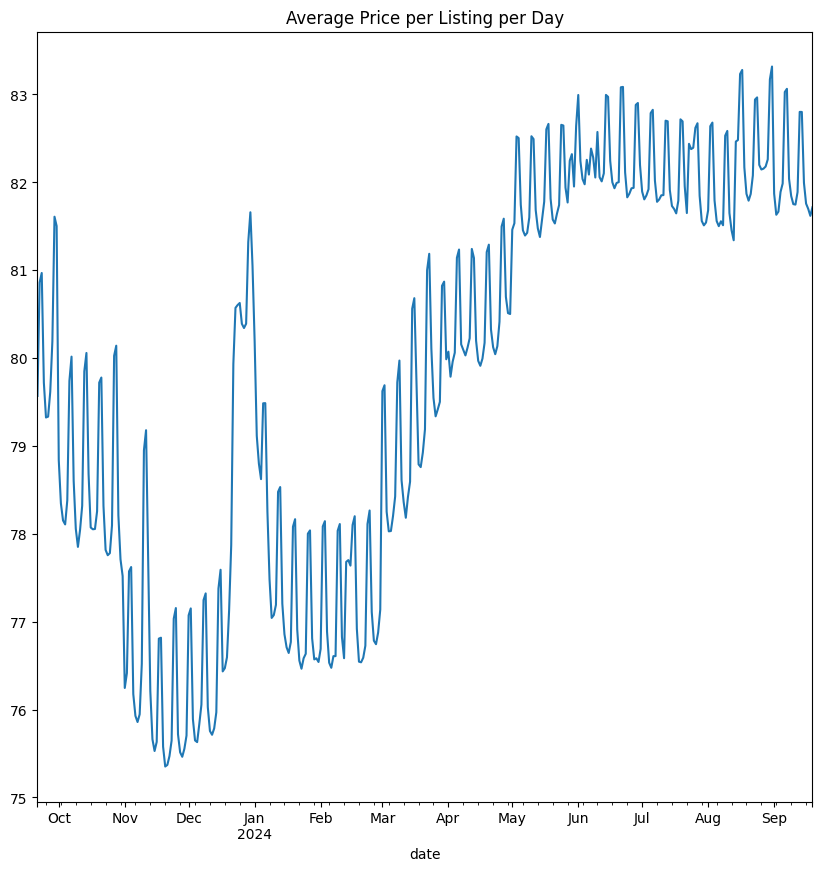

In [72]:
average_price_per_day = calendar_prices.groupby("date").mean()
average_price_per_day.plot.line(figsize=(10, 10), legend=False,title="Average Price per Listing per Day")
plt.show()

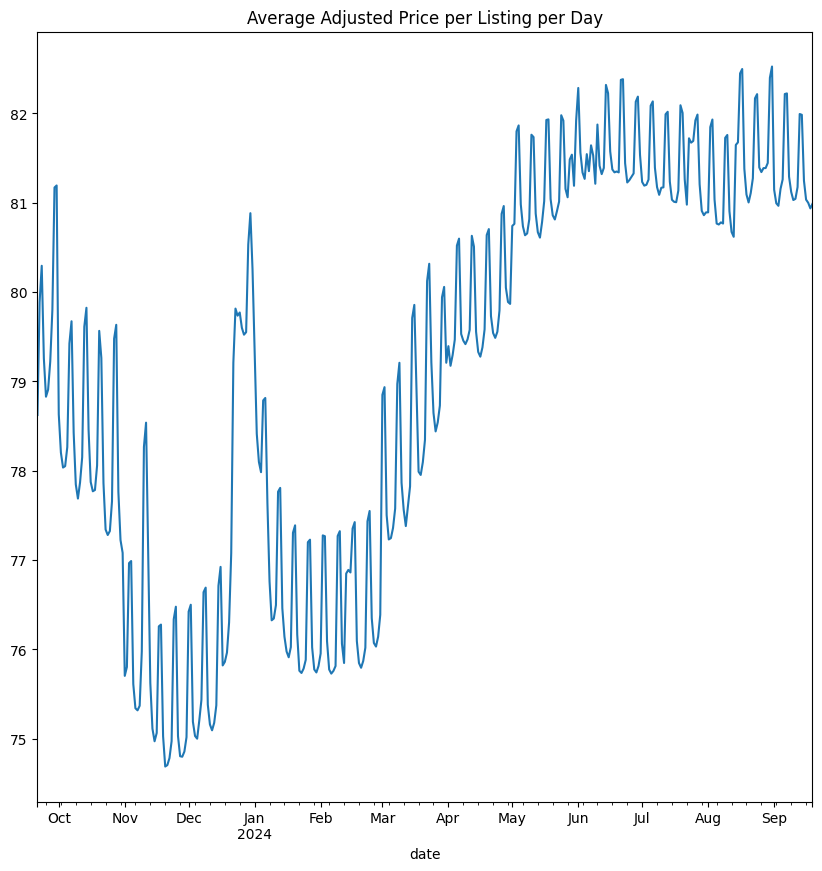

In [73]:
average_adjusted_price_per_day = calendar_adjusted_prices.groupby("date").mean()
average_adjusted_price_per_day.plot.line(figsize=(10, 10), legend=False,title="Average Adjusted Price per Listing per Day")
plt.show()

* The two graphs seem almost identical, so we can use either one of them
* The graph seems to make sense, since we see the prices going up during winter holidays, then increase again at the start of summer (June), with another increase on August-15, the biggest peak of summer holidays in Greece. On october the prices have been decreased as the summer holiday season ends.
* The often spikes are probably weekends.

## Listings per Host

Create a table with the number of listings per host, in descending order. Create a graph that will show the distribution of listings per host, as follows:

* You will rank the host on a number of listings basis. So, the first host will be the one with the largest number of listings, the second host will be the one with the second largest number of listings, etc. If there is a number of hosts with the same listings, just add them in sequence. For instance, if there are 10 hosts with one listing each, add them in the ranking with any order between them.

* On the $y$ axis you will have the number of listings.

That is, a point $(x, y)$ will mean that the $x$-th highest hosting host has $y$ listings.

After you have drawn the plot, do another one, this time with the $x$ axis in *logarithmic* scale.

* Let's see what host data we have in the listings dataset

In [74]:
listings.filter(regex="host").sample(3)

host_id                                     host_url host_name   
2690  192989050  https://www.airbnb.com/users/show/192989050  Menelaos  \
3582  241925528  https://www.airbnb.com/users/show/241925528     Aliki   
6717   47267002   https://www.airbnb.com/users/show/47267002       Tèo   

      host_since   host_location   
2690  2018-06-02          Greece  \
3582  2019-02-08             NaN   
6717  2015-10-23  Athens, Greece   

                                             host_about host_response_time   
2690                                                NaN     within an hour  \
3582                                                NaN                NaN   
6717  "The journey of a thousand miles begins with o...     within an hour   

     host_response_rate host_acceptance_rate host_is_superhost  ...   
2690               100%                  75%                 f  ...  \
3582                NaN                  NaN                 f  ...   
6717               100%                 100%                 t  ...   

     host_neighbourhood host_listings_count host_total_listings_count   
2690                NaN                 1.0                       3.0  \
3582            Kolonos                 1.0                       1.0   
6717             Attiki               132.0                     135.0   

                    host_verifications  host_has_profile_pic   
2690                ['email', 'phone']                     t  \
3582                ['email', 'phone']                     t   
6717  ['email', 'phone', 'work_email']                     t   

     host_identity_verified calculated_host_listings_count   
2690                      t                              1  \
3582                      t                              1   
6717                      t                             61   

     calculated_host_listings_count_entire_homes   
2690                                           1  \
3582                                           1   
6717                                          48   

      calculated_host_listings_count_private_rooms   
2690                                             0  \
3582                                             0   
6717                                            13   

      calculated_host_listings_count_shared_rooms  
2690                                            0  
3582                                            0  
6717                                            0  

[3 rows x 22 columns]

* Seems like we have the host_id column, let's group by that, and keep all the columns, but count the number of listings per host
* There are also some columns containing listings counts, lets calculate them manually and compare the results too.

In [75]:
listings_per_host = listings.groupby("host_id").count().sort_values(by="id", ascending=False)[["id"]].rename(columns={"id": "total_listings"})
listings_per_host.reset_index(inplace=True)
listings_per_host.head(3)

host_id  total_listings
0   20104194             114
1  113548208              88
2   90390850              78

* Let's take for instance the host with id 369675044, and see if the number of listings is correct

In [76]:
listings[listings["host_id"] == 369675044].filter(regex="host")

host_id                                     host_url host_name   
5768  369675044  https://www.airbnb.com/users/show/369675044    AthINN  \
5786  369675044  https://www.airbnb.com/users/show/369675044    AthINN   
5787  369675044  https://www.airbnb.com/users/show/369675044    AthINN   
5788  369675044  https://www.airbnb.com/users/show/369675044    AthINN   
5790  369675044  https://www.airbnb.com/users/show/369675044    AthINN   
5791  369675044  https://www.airbnb.com/users/show/369675044    AthINN   
5794  369675044  https://www.airbnb.com/users/show/369675044    AthINN   
5796  369675044  https://www.airbnb.com/users/show/369675044    AthINN   
5800  369675044  https://www.airbnb.com/users/show/369675044    AthINN   

      host_since   host_location host_about host_response_time   
5768  2020-09-28  Athens, Greece        NaN     within an hour  \
5786  2020-09-28  Athens, Greece        NaN     within an hour   
5787  2020-09-28  Athens, Greece        NaN     within an hour   
5788  2020-09-28  Athens, Greece        NaN     within an hour   
5790  2020-09-28  Athens, Greece        NaN     within an hour   
5791  2020-09-28  Athens, Greece        NaN     within an hour   
5794  2020-09-28  Athens, Greece        NaN     within an hour   
5796  2020-09-28  Athens, Greece        NaN     within an hour   
5800  2020-09-28  Athens, Greece        NaN     within an hour   

     host_response_rate host_acceptance_rate host_is_superhost  ...   
5768               100%                 100%                 f  ...  \
5786               100%                 100%                 f  ...   
5787               100%                 100%                 f  ...   
5788               100%                 100%                 f  ...   
5790               100%                 100%                 f  ...   
5791               100%                 100%                 f  ...   
5794               100%                 100%                 f  ...   
5796               100%                 100%                 f  ...   
5800               100%                 100%                 f  ...   

     host_neighbourhood host_listings_count host_total_listings_count   
5768                NaN                15.0                      16.0  \
5786                NaN                15.0                      16.0   
5787                NaN                15.0                      16.0   
5788                NaN                15.0                      16.0   
5790                NaN                15.0                      16.0   
5791                NaN                15.0                      16.0   
5794                NaN                15.0                      16.0   
5796                NaN                15.0                      16.0   
5800                NaN                15.0                      16.0   

      host_verifications  host_has_profile_pic host_identity_verified   
5768  ['email', 'phone']                     t                      t  \
5786  ['email', 'phone']                     t                      t   
5787  ['email', 'phone']                     t                      t   
5788  ['email', 'phone']                     t                      t   
5790  ['email', 'phone']                     t                      t   
5791  ['email', 'phone']                     t                      t   
5794  ['email', 'phone']                     t                      t   
5796  ['email', 'phone']                     t                      t   
5800  ['email', 'phone']                     t                      t   

     calculated_host_listings_count   
5768                              9  \
5786                              9   
5787                              9   
5788                              9   
5790                              9   
5791                              9   
5794                              9   
5796                              9   
5800                              9   

     calculated_host_listings_count_entire

In [77]:
listings_per_host[listings_per_host["host_id"] == 369675044]

host_id  total_listings
197  369675044               9

* Seems like the number of listings we calculated is correct, as the number of listings (9) matches our calculation, the listings' column may contain listings that are not inside the dataset, so we will use our calculation for the plots.

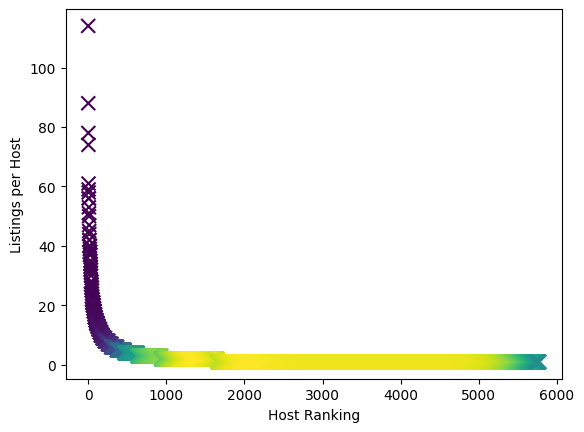

In [78]:
# use the gaussian distribution to calculate the point density
xy = np.vstack([listings_per_host.index,listings_per_host["total_listings"]])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(listings_per_host.index, listings_per_host["total_listings"], c=z, s=100,cmap=plt.cm.viridis,marker="x")
plt.xlabel("Host Ranking")
plt.ylabel("Listings per Host")
plt.show()

* The colour scale demonstrates the density of the values
* Now let's do the same plot but with the x axis in logarithmic scale

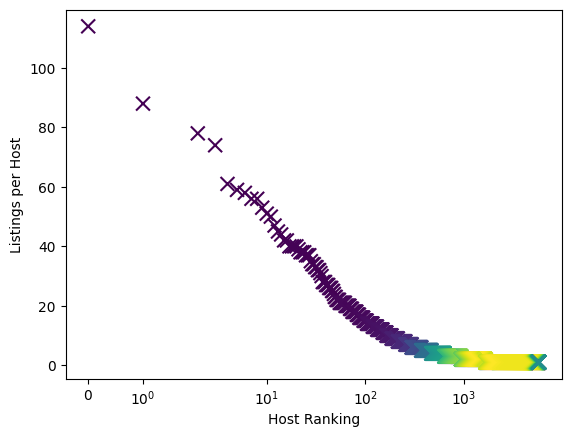

In [79]:
fig, ax = plt.subplots()
ax.scatter(listings_per_host.index, listings_per_host["total_listings"], c=z, s=100,cmap=plt.cm.viridis,marker="x")
ax.set_xscale('log')
plt.xscale('symlog') # symlog is used to display values with x <=0
plt.xlabel("Host Ranking")
plt.ylabel("Listings per Host")
plt.show()

* Let's add some interactivity to the plot, so that when we click on a point, we will see the host_id and the number of listings

In [80]:
listings_per_host.sample(3)

host_id  total_listings
1673  303705203               1
1451   34755680               2
3922   67429523               1

In [81]:
fig = px.scatter(listings_per_host, x=listings_per_host.index, y="total_listings", log_x=True, size_max=60,hover_data=['host_id', 'total_listings'])
fig.update_xaxes(title_text='Hosts ranking by number of listings')
fig.update_yaxes(title_text='Number of listings')
fig.show()

* Note: Why do we not see the first point? Because the first point is on the logarithmic scale where x=0, that is undefined. In matplotlib we tackle that with symlog, but it is not yet implemented on plotly.

## Visualize Listings

* Let's use folium to draw an interactive map to show the listings ovelayed on Athens, and save it on an HTML file.

* The map should show each listing and on clicking on top of it, the user should see a short description of the listing.

* Also, to make things easier, you make wish to limit the maximum zoom level from 12 to 15 (after you read folium's documentation you will know what this is).

* Let's create a new column with a pretty html description of each listing, so that we can use it on the map

In [82]:
listings["description_for_visualization"] = listings.apply(lambda x: f"<b>Name:</b> {x['name']}<br><b>Neighbourhood:</b> {x['neighbourhood_cleansed']}<br><b>Room Type:</b> {x['room_type']}<br><b>Beds:</b> {x['beds']}<br><b>Host:</b> {x['host_name']}<br><b>Price:</b> {x['price']}", axis=1)

In [83]:
athens = folium.Map(location=[37.983810, 23.727539], zoom_start=12, max_zoom=19)

map_listings = folium.map.FeatureGroup()

for lat, lng, desc in zip(listings["latitude"], listings["longitude"], listings["description_for_visualization"]):
    map_listings.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=1,
            color="#ff040b", # make sure that it will be visible on the map (a bit darker than the original AirBnB colour)
            fill=True,
            fill_color="#ff040b",
            fill_opacity=0.8,
            popup=desc,
        )
    )

athens.add_child(map_listings)
athens.save("./athens_map_listings.html")

* Let's also see a second approach

In [84]:
athens_map = folium.Map(location=[37.983810, 23.727539], zoom_start=12, max_zoom=19)

marker_cluster = MarkerCluster().add_to(athens_map)

for index, row in listings.iterrows():
    folium.Marker(location=[row["latitude"], row["longitude"]], popup=row["description_for_visualization"]).add_to(marker_cluster)

athens_map.save("./athens_map.html")